In [1]:
import pathlib
import dask.dataframe
import psutil
import requests, re
import pandas as pd

In [2]:
# print amount of available RAM memory
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 3.55 GB


In [3]:
# using pathlib create directory called meteo
data_dir = pathlib.Path("meteo")
data_dir.mkdir(exist_ok=True)

In [4]:
base = "https://meteo.gig.eu/archiwum/2025/"
dest = pathlib.Path("meteo")
dest.mkdir(exist_ok=True)
html = requests.get(base).text
files = re.findall(r'href="([^"]+\.\w+)"', html)
for f in files:
    url = f if f.startswith("http") else base + f
    name = pathlib.Path(url).name
    print("Downloading", name)
    with requests.get(url, stream=True) as r, open(dest/name, "wb") as out:
        for chunk in r.iter_content(1024*64):
            out.write(chunk)

In [5]:
first_file = next(data_dir.glob("*.txt"))
first_file

PosixPath('meteo/20250602.txt')

In [6]:
columns = [
    "Date",
    "Time",
    "TempOut",
    "TempHi",
    "TempLow",
    "HumOut",
    "DewPt",
    "WindSpeed",
    "WindDir",
    "WindRun",
    "WindSpeedHi",
    "WindDirHi",
    "WindChill",
    "HeatIndex",
    "THWIndex",
    "THSWIndex",
    "Bar",
    "Rain",
    "RainRate",
    "SolarRad",
    "SolarEnergy",
    "SolarRadHi",
    "UVIndex",
    "UVDose",
    "UVIndexHi",
    "HeatDD",
    "CoolDD",
    "TempIn",
    "HumIn",
    "DewPtIn",
    "HeatIn",
    "ET",
    "WindSamp",
    "WindTx",
    "ISSRecept",
    "ArcInt"
]

In [7]:
df = pd.read_csv(first_file,sep=r'\s+', names=columns, skiprows=3, na_values = ['---', '------'])
df.head()

,Date,Time,TempOut,TempHi,TempLow,HumOut,DewPt,WindSpeed,WindDir,WindRun,...,CoolDD,TempIn,HumIn,DewPtIn,HeatIn,ET,WindSamp,WindTx,ISSRecept,ArcInt
0,25-05-25,0:30,10.9,11.1,10.7,73,6.3,0.4,N,0.8,...,0.0,21.9,34,5.3,20.5,0.00,699,1,100.0,30
1,25-05-25,1:00,10.3,10.7,9.9,77,6.5,0.0,N,0.0,...,0.0,21.8,34,5.3,20.4,0.03,701,1,100.0,30
2,25-05-25,1:30,9.6,9.9,9.2,80,6.3,0.0,NaN,0.0,...,0.0,21.7,34,5.2,20.2,0.00,700,1,100.0,30
3,25-05-25,2:00,9.0,9.2,8.8,84,6.4,0.0,N,0.0,...,0.0,21.7,34,5.1,20.2,0.03,702,1,100.0,30
4,25-05-25,2:30,8.8,8.9,8.6,85,6.4,0.0,NaN,0.0,...,0.0,21.6,34,5.1,20.1,0.00,701,1,100.0,30


<Axes: xlabel='TempOut', ylabel='HumOut'>

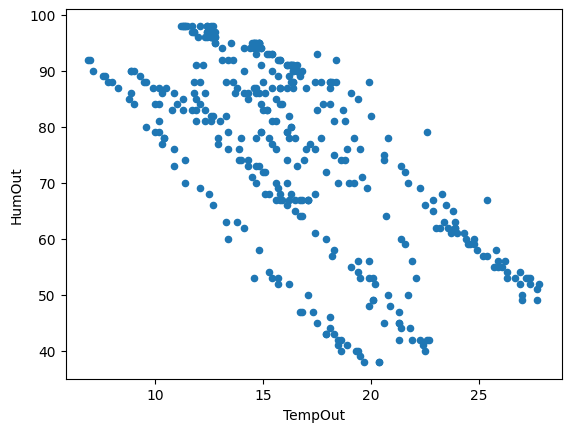

In [8]:
df.plot.scatter(x='TempOut',y='HumOut')

In [9]:
df_list = []
for file_path in data_dir.glob("*.txt"):
    df_tmp = pd.read_csv(file_path,sep=r'\s+', names=columns, skiprows=3, na_values = ['---', '------'])
    df_list.append(df_tmp)
df_all = pd.concat(df_list)
df_all

,Date,Time,TempOut,TempHi,TempLow,HumOut,DewPt,WindSpeed,WindDir,WindRun,...,CoolDD,TempIn,HumIn,DewPtIn,HeatIn,ET,WindSamp,WindTx,ISSRecept,ArcInt
0,25-05-25,0:30,10.9,11.1,10.7,73.0,6.3,0.4,N,0.80,...,0.0,21.9,34.0,5.3,20.5,0.00,699,1,100.0,30
1,25-05-25,1:00,10.3,10.7,9.9,77.0,6.5,0.0,N,0.00,...,0.0,21.8,34.0,5.3,20.4,0.03,701,1,100.0,30
2,25-05-25,1:30,9.6,9.9,9.2,80.0,6.3,0.0,NaN,0.00,...,0.0,21.7,34.0,5.2,20.2,0.00,700,1,100.0,30
3,25-05-25,2:00,9.0,9.2,8.8,84.0,6.4,0.0,N,0.00,...,0.0,21.7,34.0,5.1,20.2,0.03,702,1,100.0,30
4,25-05-25,2:30,8.8,8.9,8.6,85.0,6.4,0.0,NaN,0.00,...,0.0,21.6,34.0,5.1,20.1,0.00,701,1,100.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,25-05-04,22:00,11.4,11.6,11.2,68.0,5.7,0.9,N,1.61,...,0.0,24.6,34.0,7.7,23.8,0.03,701,1,100.0,30
380,25-05-04,22:30,11.1,11.2,10.9,70.0,5.8,0.9,N,1.61,...,0.0,24.5,34.0,7.6,23.7,0.00,699,1,100.0,30
381,25-05-04,23:00,10.8,10.9,10.6,70.0,5.6,0.9,N,1.61,...,0.0,24.3,34.0,7.5,23.5,0.03,703,1,100.0,30
382,25-05-04,23:30,10.4,10.6,10.3,71.0,5.4,0.9,N,1.61,...,0.0,24.2,34.0,7.4,23.4,0.00,699,1,100.0,30


In [10]:
df_all.dtypes

Date            object
Time            object
TempOut        float64
TempHi         float64
TempLow        float64
HumOut         float64
DewPt          float64
WindSpeed      float64
WindDir         object
WindRun        float64
WindSpeedHi    float64
WindDirHi       object
WindChill      float64
HeatIndex      float64
THWIndex       float64
THSWIndex      float64
Bar            float64
Rain           float64
RainRate       float64
SolarRad       float64
SolarEnergy    float64
SolarRadHi     float64
UVIndex        float64
UVDose         float64
UVIndexHi      float64
HeatDD         float64
CoolDD         float64
TempIn         float64
HumIn          float64
DewPtIn        float64
HeatIn         float64
ET             float64
WindSamp         int64
WindTx           int64
ISSRecept      float64
ArcInt           int64
dtype: object

<Axes: xlabel='TempOut', ylabel='HumOut'>

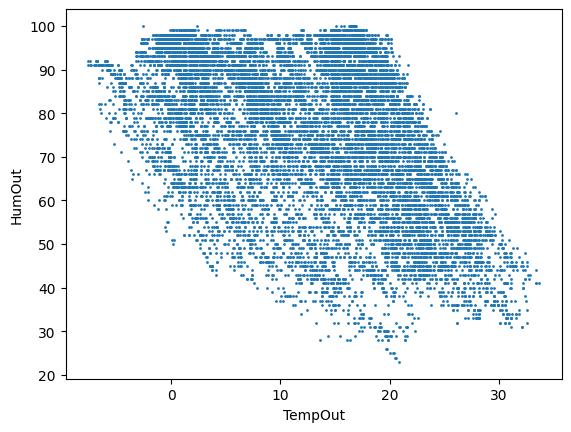

In [11]:
df_all.plot.scatter(x='TempOut',y='HumOut', s=1)

In [12]:
# read all files using dask
df_dask = dask.dataframe.read_csv(
       data_dir/"*.txt", sep=r'\s+', names=columns, skiprows=3, na_values = ['---', '------'], 
       dtype={'HumIn': 'float64',
              'HumOut': 'float64',
              'SolarRad': 'float64',
              'SolarRadHi': 'float64'}
       )
df_dask.head()

,Date,Time,TempOut,TempHi,TempLow,HumOut,DewPt,WindSpeed,WindDir,WindRun,...,CoolDD,TempIn,HumIn,DewPtIn,HeatIn,ET,WindSamp,WindTx,ISSRecept,ArcInt
0,24-12-29,0:30,0.4,0.4,0.3,98.0,0.1,0.0,NE,0.0,...,0.0,18.4,30.0,0.5,16.4,0.0,699,1,100.0,30
1,24-12-29,1:00,0.1,0.3,-0.1,98.0,-0.2,0.0,NE,0.0,...,0.0,18.4,30.0,0.5,16.4,0.0,699,1,100.0,30
2,24-12-29,1:30,-0.2,-0.1,-0.3,98.0,-0.5,0.0,NE,0.0,...,0.0,18.3,30.0,0.4,16.4,0.0,699,1,100.0,30
3,24-12-29,2:00,-0.3,-0.3,-0.4,98.0,-0.6,0.0,NE,0.0,...,0.0,18.3,30.0,0.4,16.3,0.0,700,1,100.0,30
4,24-12-29,2:30,-0.5,-0.4,-0.6,98.0,-0.8,0.0,NE,0.0,...,0.0,18.3,30.0,0.4,16.3,0.0,701,1,100.0,30


In [13]:
df_dask.dtypes

Date           string[pyarrow]
Time           string[pyarrow]
TempOut                float64
TempHi                 float64
TempLow                float64
HumOut                 float64
DewPt                  float64
WindSpeed              float64
WindDir        string[pyarrow]
WindRun                float64
WindSpeedHi            float64
WindDirHi      string[pyarrow]
WindChill              float64
HeatIndex              float64
THWIndex               float64
THSWIndex              float64
Bar                    float64
Rain                   float64
RainRate               float64
SolarRad               float64
SolarEnergy            float64
SolarRadHi             float64
UVIndex                float64
UVDose                 float64
UVIndexHi              float64
HeatDD                 float64
CoolDD                 float64
TempIn                 float64
HumIn                  float64
DewPtIn                float64
HeatIn                 float64
ET                     float64
WindSamp

<Axes: xlabel='TempOut', ylabel='HumOut'>

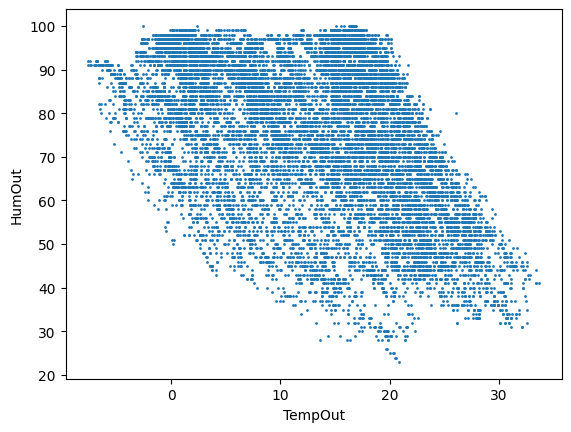

In [14]:
df_dask.compute().plot.scatter(x='TempOut',y='HumOut', s=1)

In [15]:
dask_out_path = data_dir/"meteo_dask.h5"
df_dask.to_hdf(dask_out_path, key='df', mode='w');

# print size of the created file
print(f"Size of the created file: {dask_out_path.stat().st_size / (1024**2):.2f} MB")

Size of the created file: 3.94 MB


In [16]:
df_dask.to_hdf(dask_out_path, key='df', mode='w', complevel=9);
print(f"Size of the created file: {dask_out_path.stat().st_size / (1024**2):.2f} MB")

Size of the created file: 0.75 MB


In [17]:
# exercise: extend the notebook to read the data from 2006 until now

In [18]:
# work on datatype, replace some object types with categorical or string